# **DATA PREPROCESSING**

In [5]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import f1_score, average_precision_score, classification_report, confusion_matrix
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv1D, MaxPooling1D, GRU, LSTM, Dense, Dropout, BatchNormalization, Concatenate
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.optimizers import Adam
import inspect

In [3]:
data = pd.read_csv('day_approach_maskedID_timeseries.csv')

In [4]:
# Filter only columns that do NOT contain '.1', '.2', ..., '.6'
base_feature_cols = [col for col in data.columns
                     if not any(col.endswith(f".{i}") for i in range(1, 7))
                     and col not in ['Athlete ID', 'Date', 'injury']]

# Keep only core features + ID + Date + target
filtered_df = data[base_feature_cols + ['Athlete ID', 'Date', 'injury']]

In [47]:
# --- Section 1: Data Normalization ---
def normalize_data(df, base_feature_cols, strategy='athlete'):
    df_norm = df.copy()
    if strategy == 'global':
        scaler = StandardScaler()
        df_norm[base_feature_cols] = scaler.fit_transform(df[base_feature_cols])
    elif strategy == 'athlete':
        for athlete_id, group in df.groupby('Athlete ID'):
            scaler = StandardScaler()
            df_norm.loc[group.index, base_feature_cols] = scaler.fit_transform(group[base_feature_cols])
    else:
        raise ValueError("Invalid normalization strategy")
    return df_norm


In [5]:
# --- Section 2: Sliding Window Creation ---
def create_windows_with_athlete_tracking(df, feature_cols, window_size=20, risk_horizon=5):
    X, y, athlete_ids = [], [], []
    df = df.sort_values(['Athlete ID', 'Date'])
    for athlete_id, group in df.groupby('Athlete ID'):
        group = group.reset_index(drop=True)
        injuries = group['injury'].values
        features = group[feature_cols].values
        for i in range(len(group) - window_size - risk_horizon):
            window = features[i:i+window_size]
            injury_window = injuries[i+window_size:i+window_size + risk_horizon]
            label = 1 if injury_window.any() else 0
            X.append(window)
            y.append(label)
            athlete_ids.append(athlete_id)
    return np.array(X), np.array(y), np.array(athlete_ids)

In [6]:
# --- Section 3: Engineered Feature Extraction ---
def extract_features_from_window(window):
    features = []
    for i in range(window.shape[1]):
        series = window[:, i]
        features.extend([
            np.mean(series), np.std(series), np.min(series),
            np.max(series), np.polyfit(np.arange(len(series)), series, 1)[0], series[-1]
        ])
    return np.array(features)

In [7]:
def extract_engineered_features(X):
    return np.array([extract_features_from_window(w) for w in X])

In [8]:
# --- Section 4: Data Splitting ---
def split_data_by_athlete(X, X_feat, y, athlete_ids, test_size=0.2, random_state=42):
    unique_athletes = np.unique(athlete_ids)
    train_athletes, test_athletes = train_test_split(unique_athletes, test_size=test_size, random_state=random_state)
    train_mask = np.isin(athlete_ids, train_athletes)
    test_mask = np.isin(athlete_ids, test_athletes)

    return (
        X[train_mask], X[test_mask],
        X_feat[train_mask], X_feat[test_mask],
        y[train_mask], y[test_mask]
    )

# **MODELS**


In [9]:
def build_lstm_model(input_shape_ts):
    input_ts = Input(shape=input_shape_ts)
    x = LSTM(16, return_sequences=False, dropout=0.3, recurrent_dropout=0.2)(input_ts)
    x = Dropout(0.5)(x)
    x = Dense(32, activation='relu')(x)
    x = Dropout(0.3)(x)
    output = Dense(1, activation='sigmoid')(x)
    model = Model(inputs=input_ts, outputs=output)
    model.compile(loss='binary_crossentropy', optimizer=Adam(1e-3),
                  metrics=['Precision', 'Recall', tf.keras.metrics.AUC(name='AUC')])
    return model

In [10]:
def build_gru_model(input_shape_ts):
    input_ts = Input(shape=input_shape_ts)
    x = GRU(32, return_sequences=False, dropout=0.2, recurrent_dropout=0.2)(input_ts)
    x = Dropout(0.5)(x)
    x = Dense(32, activation='relu')(x)
    x = Dropout(0.3)(x)
    output = Dense(1, activation='sigmoid')(x)
    model = Model(inputs=input_ts, outputs=output)
    model.compile(loss='binary_crossentropy', optimizer=Adam(1e-3),
                  metrics=['Precision', 'Recall', tf.keras.metrics.AUC(name='AUC')])
    return model

In [11]:
def build_hybrid_model(input_shape_ts, input_shape_feat):
    input_ts = Input(shape=input_shape_ts)
    x = Conv1D(64, kernel_size=3, activation='relu')(input_ts)
    x = BatchNormalization()(x)
    x = MaxPooling1D(pool_size=2)(x)
    x = GRU(32, return_sequences=False, dropout=0.2, recurrent_dropout=0.2)(x)
    x = Dropout(0.5)(x)

    input_feat = Input(shape=(input_shape_feat,))
    y = Dense(64, activation='relu')(input_feat)
    y = Dropout(0.3)(y)
    y = Dense(32, activation='relu')(y)

    combined = Concatenate()([x, y])
    z = Dense(32, activation='relu')(combined)
    z = Dropout(0.3)(z)
    output = Dense(1, activation='sigmoid')(z)

    model = Model(inputs=[input_ts, input_feat], outputs=output)
    model.compile(loss='binary_crossentropy', optimizer=Adam(1e-3),
                  metrics=['Precision', 'Recall', tf.keras.metrics.AUC(name='AUC')])
    return model

In [12]:
def focal_loss(gamma=2., alpha=0.25):
    def focal_loss_fixed(y_true, y_pred):
        epsilon = tf.keras.backend.epsilon()
        y_pred = tf.keras.backend.clip(y_pred, epsilon, 1. - epsilon)
        cross_entropy = -y_true * tf.keras.backend.log(y_pred) - (1 - y_true) * tf.keras.backend.log(1 - y_pred)
        weight = alpha * y_true * tf.keras.backend.pow(1 - y_pred, gamma) + (1 - alpha) * (1 - y_true) * tf.keras.backend.pow(y_pred, gamma)
        return tf.keras.backend.mean(weight * cross_entropy)
    return focal_loss_fixed

In [13]:
def get_class_weights(y_train):
    weights = compute_class_weight(class_weight='balanced', classes=np.unique(y_train), y=y_train)
    return dict(zip(np.unique(y_train), weights))

# **MODEL EVALUATION**

In [14]:
def evaluate_model(model, X_test_ts, X_test_feat, y_test):
    y_probs = model.predict([X_test_ts, X_test_feat]).ravel()
    pr_auc = average_precision_score(y_test, y_probs)
    best_thresh, best_f1 = 0, 0
    for t in np.linspace(0, 1, 100):
        preds = (y_probs > t).astype(int)
        f1 = f1_score(y_test, preds)
        if f1 > best_f1:
            best_f1, best_thresh = f1, t
    final_preds = (y_probs > best_thresh).astype(int)
    report = classification_report(y_test, final_preds, output_dict=True)
    matrix = confusion_matrix(y_test, final_preds)
    return pr_auc, best_f1, best_thresh, report, matrix

# **EXPERIMENTATION**

In [15]:
# --- Section 7: Experiment Runner ---
def run_experiment(model_builder,
                   X_train_ts, X_test_ts,
                   X_train_feat, X_test_feat,
                   y_train, y_test,
                   class_weight=None,
                   loss_function='binary_crossentropy',
                   model_name='model',
                   epochs=20, batch_size=64):
    """
    model_builder: function to build the model (e.g., build_gru_model)
    class_weight: dict or None
    loss_function: string or tf.keras loss function (e.g., focal_loss())
    """
    input_shape_ts = X_train_ts.shape[1:]
    input_shape_feat = X_train_feat.shape[1] if X_train_feat is not None else None

    # Build model
    if input_shape_feat is not None and 'hybrid' in model_name:
        model = model_builder(input_shape_ts, input_shape_feat)
    else:
        model = model_builder(input_shape_ts)

    model.compile(
        optimizer=Adam(1e-3),
        loss=loss_function,
        metrics=['Precision', 'Recall', tf.keras.metrics.AUC(name='AUC')]
    )

    # Train model
    model.fit(
        [X_train_ts, X_train_feat] if input_shape_feat else X_train_ts,
        y_train,
        validation_data=(
            ([X_test_ts, X_test_feat] if input_shape_feat else X_test_ts, y_test)
        ),
        class_weight=class_weight,
        epochs=epochs,
        batch_size=batch_size,
        callbacks=[EarlyStopping(patience=3, restore_best_weights=True)],
        verbose=1
    )

    # Evaluate model
    y_probs = model.predict([X_test_ts, X_test_feat] if input_shape_feat else X_test_ts).ravel()
    pr_auc = average_precision_score(y_test, y_probs)
    best_thresh, best_f1 = 0, 0
    for t in np.linspace(0, 1, 100):
        preds = (y_probs > t).astype(int)
        f1 = f1_score(y_test, preds)
        if f1 > best_f1:
            best_f1, best_thresh = f1, t
    final_preds = (y_probs > best_thresh).astype(int)
    report = classification_report(y_test, final_preds, output_dict=True)
    matrix = confusion_matrix(y_test, final_preds)

    # Print key results
    print(f"\nModel: {model_name}")
    print(f"Best Threshold: {best_thresh:.2f}")
    print(f"PR AUC: {pr_auc:.3f}, Best F1: {best_f1:.3f}")
    print("Classification Report:")
    print(classification_report(y_test, final_preds, digits=3))
    print("Confusion Matrix:")
    print(matrix)

    # Return all metrics
    return {
        'model_name': model_name,
        'pr_auc': pr_auc,
        'best_f1': best_f1,
        'best_thresh': best_thresh,
        'report': report,
        'confusion_matrix': matrix
    }

LSTM Model experiments

In [21]:
# --- Run Full Pipeline for LSTM ---
# Step 1: Normalize Data
#df_norm = normalize_data(filtered_df, base_feature_cols, strategy='athlete')
df_norm = filtered_df

# Step 2: Create Time Windows
X, y, athlete_ids = create_windows_with_athlete_tracking(df_norm, base_feature_cols, window_size=30, risk_horizon=5)

# Step 3: No need for engineered features
X_feat = np.zeros((X.shape[0], 1))  # Dummy placeholder

# Step 4: Split the Data
X_train_ts, X_test_ts, _, _, y_train, y_test = split_data_by_athlete(X, X_feat, y, athlete_ids)

# Step 5: Train and Evaluate LSTM
results_lstm = run_experiment(
    model_builder=build_lstm_model,
    X_train_ts=X_train_ts,
    X_test_ts=X_test_ts,
    X_train_feat=None,
    X_test_feat=None,
    y_train=y_train,
    y_test=y_test,
    class_weight=get_class_weights(y_train),
    loss_function='binary_crossentropy',
    model_name='LSTM'
)


Epoch 1/20
540/540 ━━━━━━━━━━━━━━━━━━━━ 21s 27ms/step - AUC: 0.5127 - Precision: 0.0480 - Recall: 0.4599 - loss: 0.6913 - val_AUC: 0.5558 - val_Precision: 0.0427 - val_Recall: 0.7807 - val_loss: 0.7117
Epoch 2/20
540/540 ━━━━━━━━━━━━━━━━━━━━ 13s 25ms/step - AUC: 0.5228 - Precision: 0.0486 - Recall: 0.5080 - loss: 0.6797 - val_AUC: 0.5486 - val_Precision: 0.0426 - val_Recall: 0.8158 - val_loss: 0.7189
Epoch 3/20
540/540 ━━━━━━━━━━━━━━━━━━━━ 20s 25ms/step - AUC: 0.5381 - Precision: 0.0508 - Recall: 0.5826 - loss: 0.6859 - val_AUC: 0.5632 - val_Precision: 0.0493 - val_Recall: 0.5044 - val_loss: 0.6869
Epoch 4/20
540/540 ━━━━━━━━━━━━━━━━━━━━ 21s 25ms/step - AUC: 0.5412 - Precision: 0.0530 - Recall: 0.5056 - loss: 0.6951 - val_AUC: 0.5548 - val_Precision: 0.0520 - val_Recall: 0.3684 - val_loss: 0.6659
Epoch 5/20
540/540 ━━━━━━━━━━━━━━━━━━━━ 20s 25ms/step - AUC: 0.5382 - Precision: 0.0547 - Recall: 0.5486 - loss: 0.7113 - val_AUC: 0.5639 - val_Precision: 0.0495 - val_Recall: 0.4167 - val_los

In [22]:
results_lstm_focal = run_experiment(
    model_builder=build_lstm_model,
    X_train_ts=X_train_ts,
    X_test_ts=X_test_ts,
    X_train_feat=None,
    X_test_feat=None,
    y_train=y_train,
    y_test=y_test,
    class_weight=None,  # focal loss replaces this
    loss_function=focal_loss(gamma=2.0, alpha=0.25),
    model_name='LSTM_Focal'
)


Epoch 1/20
540/540 ━━━━━━━━━━━━━━━━━━━━ 20s 26ms/step - AUC: 0.5036 - Precision: 0.0538 - Recall: 0.0549 - loss: 0.0418 - val_AUC: 0.5042 - val_Precision: 0.0000e+00 - val_Recall: 0.0000e+00 - val_loss: 0.0165
Epoch 2/20
540/540 ━━━━━━━━━━━━━━━━━━━━ 20s 26ms/step - AUC: 0.4981 - Precision: 0.0000e+00 - Recall: 0.0000e+00 - loss: 0.0221 - val_AUC: 0.5168 - val_Precision: 0.0000e+00 - val_Recall: 0.0000e+00 - val_loss: 0.0163
Epoch 3/20
540/540 ━━━━━━━━━━━━━━━━━━━━ 20s 25ms/step - AUC: 0.5138 - Precision: 0.0000e+00 - Recall: 0.0000e+00 - loss: 0.0196 - val_AUC: 0.5177 - val_Precision: 0.0000e+00 - val_Recall: 0.0000e+00 - val_loss: 0.0165
Epoch 4/20
540/540 ━━━━━━━━━━━━━━━━━━━━ 13s 24ms/step - AUC: 0.5144 - Precision: 0.0000e+00 - Recall: 0.0000e+00 - loss: 0.0199 - val_AUC: 0.4971 - val_Precision: 0.0000e+00 - val_Recall: 0.0000e+00 - val_loss: 0.0165
Epoch 5/20
540/540 ━━━━━━━━━━━━━━━━━━━━ 21s 24ms/step - AUC: 0.5110 - Precision: 0.0000e+00 - Recall: 0.0000e+00 - loss: 0.0193 - val_AU

GRU Only Model Experiments

In [24]:
# --- Run Full Pipeline for GRU-only Model ---
# Step 1: Normalize Data
#df_norm = normalize_data(filtered_df, base_feature_cols, strategy='athlete')
df_norm = filtered_df

# Step 2: Create Time Windows
X, y, athlete_ids = create_windows_with_athlete_tracking(df_norm, base_feature_cols, window_size=20, risk_horizon=5)

# Step 3: Create dummy features (not needed for GRU)
X_feat_dummy = np.zeros((X.shape[0], 1))  # Placeholder

# Step 4: Split Data
X_train_ts, X_test_ts, _, _, y_train, y_test = split_data_by_athlete(X, X_feat_dummy, y, athlete_ids)

# Step 5: Run GRU model
results_gru = run_experiment(
    model_builder=build_gru_model,
    X_train_ts=X_train_ts,
    X_test_ts=X_test_ts,
    X_train_feat=None,
    X_test_feat=None,
    y_train=y_train,
    y_test=y_test,
    class_weight=get_class_weights(y_train),
    loss_function='binary_crossentropy',
    model_name='GRU'
)


Epoch 1/20
549/549 ━━━━━━━━━━━━━━━━━━━━ 18s 21ms/step - AUC: 0.4771 - Precision: 0.0421 - Recall: 0.4112 - loss: 0.7160 - val_AUC: 0.5522 - val_Precision: 0.0442 - val_Recall: 0.8103 - val_loss: 0.7047
Epoch 2/20
549/549 ━━━━━━━━━━━━━━━━━━━━ 11s 20ms/step - AUC: 0.5219 - Precision: 0.0500 - Recall: 0.5253 - loss: 0.6986 - val_AUC: 0.5561 - val_Precision: 0.0427 - val_Recall: 0.7931 - val_loss: 0.7104
Epoch 3/20
549/549 ━━━━━━━━━━━━━━━━━━━━ 20s 20ms/step - AUC: 0.5233 - Precision: 0.0501 - Recall: 0.5066 - loss: 0.6977 - val_AUC: 0.5572 - val_Precision: 0.0436 - val_Recall: 0.6595 - val_loss: 0.7015
Epoch 4/20
549/549 ━━━━━━━━━━━━━━━━━━━━ 21s 20ms/step - AUC: 0.5602 - Precision: 0.0552 - Recall: 0.5659 - loss: 0.6885 - val_AUC: 0.5492 - val_Precision: 0.0498 - val_Recall: 0.4267 - val_loss: 0.6747
Epoch 5/20
549/549 ━━━━━━━━━━━━━━━━━━━━ 20s 20ms/step - AUC: 0.5651 - Precision: 0.0554 - Recall: 0.5406 - loss: 0.6823 - val_AUC: 0.5304 - val_Precision: 0.0458 - val_Recall: 0.3966 - val_los

In [64]:
# Step 5: Run GRU model with focal loss
results_gru = run_experiment(
    model_builder=build_gru_model,
    X_train_ts=X_train_ts,
    X_test_ts=X_test_ts,
    X_train_feat=None,
    X_test_feat=None,
    y_train=y_train,
    y_test=y_test,
    class_weight=None,
    loss_function=focal_loss(gamma=2.0, alpha=0.25),
    model_name='GRU_Focal'
)

Epoch 1/20
549/549 ━━━━━━━━━━━━━━━━━━━━ 15s 19ms/step - AUC: 0.5052 - Precision: 0.0405 - Recall: 0.0328 - loss: 0.0413 - val_AUC: 0.5625 - val_Precision: 0.0000e+00 - val_Recall: 0.0000e+00 - val_loss: 0.0175
Epoch 2/20
549/549 ━━━━━━━━━━━━━━━━━━━━ 10s 18ms/step - AUC: 0.5040 - Precision: 0.0000e+00 - Recall: 0.0000e+00 - loss: 0.0221 - val_AUC: 0.5790 - val_Precision: 0.0000e+00 - val_Recall: 0.0000e+00 - val_loss: 0.0162
Epoch 3/20
549/549 ━━━━━━━━━━━━━━━━━━━━ 11s 18ms/step - AUC: 0.5392 - Precision: 0.0000e+00 - Recall: 0.0000e+00 - loss: 0.0197 - val_AUC: 0.5749 - val_Precision: 0.0000e+00 - val_Recall: 0.0000e+00 - val_loss: 0.0170
Epoch 4/20
549/549 ━━━━━━━━━━━━━━━━━━━━ 9s 15ms/step - AUC: 0.5396 - Precision: 0.0000e+00 - Recall: 0.0000e+00 - loss: 0.0193 - val_AUC: 0.5751 - val_Precision: 0.0000e+00 - val_Recall: 0.0000e+00 - val_loss: 0.0172
Epoch 5/20
549/549 ━━━━━━━━━━━━━━━━━━━━ 10s 17ms/step - AUC: 0.5477 - Precision: 0.0000e+00 - Recall: 0.0000e+00 - loss: 0.0193 - val_AUC

Hybrid Model


In [25]:
# --- Run Full Pipeline for Hybrid Model with BCE + Class Weights ---

# Step 1: Normalize Data
#df_norm = normalize_data(filtered_df, base_feature_cols, strategy='athlete')
df_norm = filtered_df
# Step 2: Create Time Windows
X, y, athlete_ids = create_windows_with_athlete_tracking(filtered_df, base_feature_cols, window_size=30, risk_horizon=5)

# Step 3: Extract Engineered Features
X_feat = np.array([extract_features_from_window(w) for w in X])

# Step 4: Split Data
X_train_ts, X_test_ts, X_train_feat, X_test_feat, y_train, y_test = split_data_by_athlete(X, X_feat, y, athlete_ids)

# Step 5: Train and Evaluate Hybrid Model
results_hybrid_bce = run_experiment(
    model_builder=build_hybrid_model,
    X_train_ts=X_train_ts,
    X_test_ts=X_test_ts,
    X_train_feat=X_train_feat,
    X_test_feat=X_test_feat,
    y_train=y_train,
    y_test=y_test,
    class_weight=get_class_weights(y_train),
    loss_function='binary_crossentropy',
    model_name='hybrid'
)


Epoch 1/20
540/540 ━━━━━━━━━━━━━━━━━━━━ 21s 26ms/step - AUC: 0.5074 - Precision: 0.0472 - Recall: 0.4219 - loss: 0.7355 - val_AUC: 0.6064 - val_Precision: 0.0430 - val_Recall: 0.8553 - val_loss: 0.7236
Epoch 2/20
540/540 ━━━━━━━━━━━━━━━━━━━━ 20s 24ms/step - AUC: 0.5663 - Precision: 0.0587 - Recall: 0.5957 - loss: 0.6942 - val_AUC: 0.6152 - val_Precision: 0.0619 - val_Recall: 0.4649 - val_loss: 0.6242
Epoch 3/20
540/540 ━━━━━━━━━━━━━━━━━━━━ 21s 25ms/step - AUC: 0.6261 - Precision: 0.0658 - Recall: 0.6210 - loss: 0.6705 - val_AUC: 0.5679 - val_Precision: 0.0855 - val_Recall: 0.2763 - val_loss: 0.5035
Epoch 4/20
540/540 ━━━━━━━━━━━━━━━━━━━━ 20s 24ms/step - AUC: 0.6217 - Precision: 0.0690 - Recall: 0.5826 - loss: 0.6746 - val_AUC: 0.5427 - val_Precision: 0.0536 - val_Recall: 0.3684 - val_loss: 0.6261
Epoch 5/20
540/540 ━━━━━━━━━━━━━━━━━━━━ 21s 25ms/step - AUC: 0.6422 - Precision: 0.0686 - Recall: 0.6193 - loss: 0.6557 - val_AUC: 0.5224 - val_Precision: 0.0439 - val_Recall: 0.4123 - val_los

In [111]:
def run_bagged_hybrid_model(df, feature_cols, window_func, build_model_func, extract_features_from_window, n_models=5, window_size=20, risk_horizon=5):
    from sklearn.model_selection import train_test_split
    from sklearn.utils import resample

    unique_athletes = df['Athlete ID'].unique()
    fixed_test_athletes = np.random.choice(unique_athletes, size=int(0.2 * len(unique_athletes)), replace=False)
    all_probs = []
    y_test_final = None

    for seed in range(n_models):
        np.random.seed(seed)
        sampled_athletes = np.random.choice(unique_athletes, size=len(unique_athletes), replace=True)
        sampled_df = pd.concat([df[df['Athlete ID'] == aid] for aid in sampled_athletes])

        X, y, athlete_ids = window_func(sampled_df, feature_cols, window_size, risk_horizon)
        X_feat = np.array([extract_features_from_window(w) for w in X])

        train_mask = np.isin(athlete_ids, sampled_athletes) & ~np.isin(athlete_ids, fixed_test_athletes)
        test_mask = np.isin(athlete_ids, fixed_test_athletes)

        X_train_ts, X_test_ts = X[train_mask], X[test_mask]
        X_train_feat, X_test_feat = X_feat[train_mask], X_feat[test_mask]
        y_train, y_test = y[train_mask], y[test_mask]

        # Fix: Always use hybrid signature correctly
        model = build_model_func(X_train_ts.shape[1:], X_train_feat.shape[1])

        model.compile(loss='binary_crossentropy', optimizer='adam',
                      metrics=['Precision', 'Recall', tf.keras.metrics.AUC()])
        model.fit([X_train_ts, X_train_feat], y_train, epochs=20, batch_size=64, verbose=0)

        y_probs = model.predict([X_test_ts, X_test_feat]).ravel()
        all_probs.append(y_probs)
        y_test_final = y_test

    # Ensure all prediction arrays are same length before averaging
    min_len = min(len(probs) for probs in all_probs)
    all_probs_trimmed = [probs[:min_len] for probs in all_probs]
    y_test_final = y_test_final[:min_len]

    y_probs_avg = np.mean(np.array(all_probs_trimmed), axis=0)

    best_f1, best_thresh = 0, 0
    for t in np.linspace(0, 1, 100):
        preds = (y_probs_avg > t).astype(int)
        f1 = f1_score(y_test_final, preds)
        if f1 > best_f1:
            best_f1, best_thresh = f1, t

    pr_auc = average_precision_score(y_test_final, y_probs_avg)
    print(f"Bagged Hybrid: PR AUC: {pr_auc:.3f}, Best F1: {best_f1:.3f} at threshold {best_thresh:.2f}")

    return y_probs_avg, y_test_final, best_thresh


In [112]:
y_probs, y_test, best_thresh = run_bagged_hybrid_model(
    df=filtered_df,
    feature_cols=base_feature_cols,
    window_func=create_windows_with_athlete_tracking,
    build_model_func=build_hybrid_model,
    extract_features_from_window=extract_features_from_window,
    n_models=5,
    window_size=20,
    risk_horizon=5
)


94/94 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step
216/216 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step
136/136 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step
205/205 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step
116/116 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step
Bagged Hybrid: PR AUC: 0.043, Best F1: 0.080 at threshold 0.00


<ipython-input-6-7c699c707f4d>:60: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=results_df, x="Model", y="F1", palette="Blues_d")


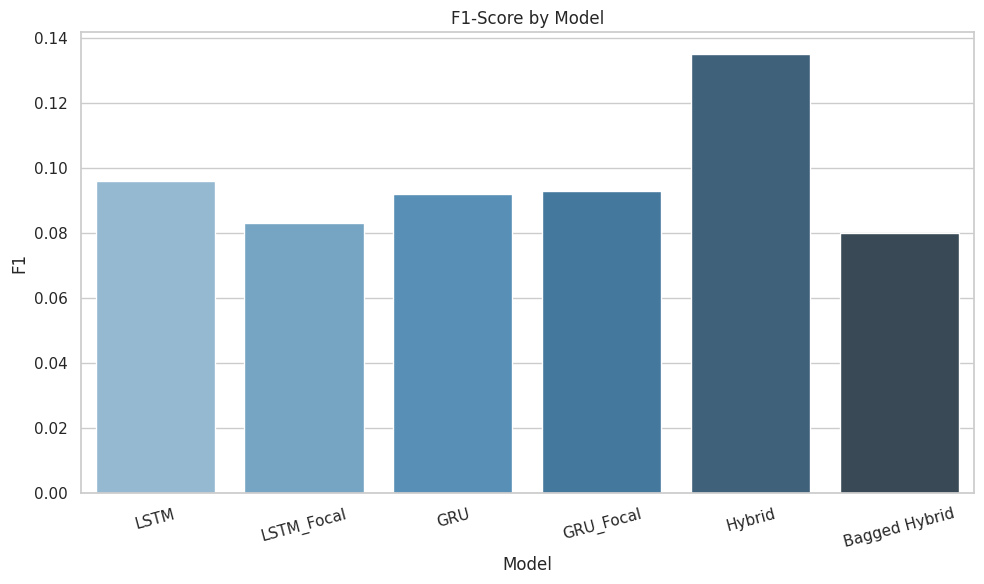

<ipython-input-6-7c699c707f4d>:68: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=results_df, x="Model", y="PR AUC", palette="Greens_d")


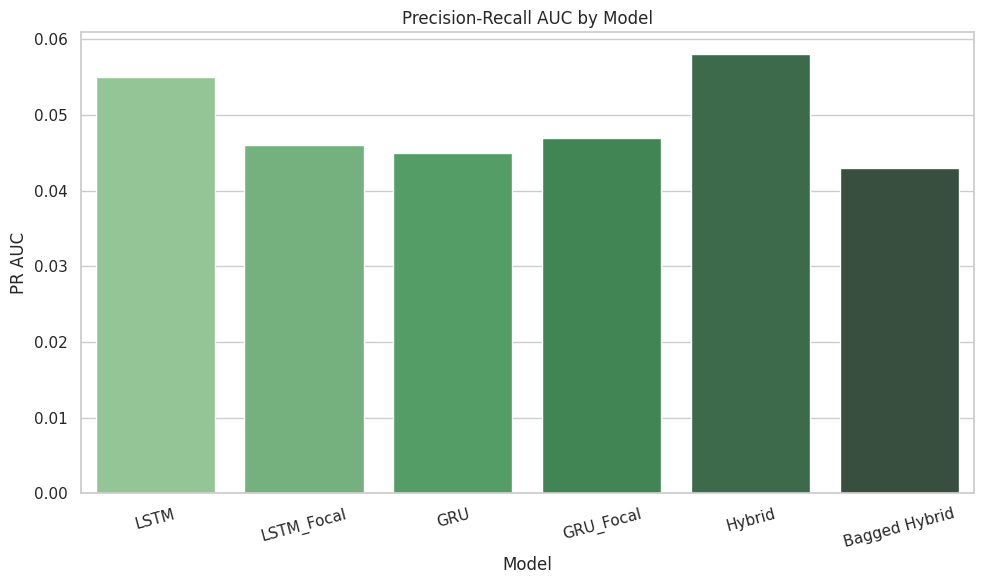

Summary table saved as model_comparison_results.csv


,Model,PR AUC,F1,Precision,Recall
0,LSTM,0.055,0.096,0.065,0.184
1,LSTM_Focal,0.046,0.083,0.044,0.934
2,GRU,0.045,0.092,0.058,0.228
3,GRU_Focal,0.047,0.093,0.050,0.733
4,Hybrid,0.058,0.135,0.093,0.246
5,Bagged Hybrid,0.043,0.080,0.055,0.211


In [6]:
# --- Results Comparison and Visualization ---

import matplotlib.pyplot as plt
import seaborn as sns

# Set plotting style
sns.set(style="whitegrid")

# Define a list of dictionaries with updated results
results_summary = [
    {
        "Model": "LSTM",
        "PR AUC": 0.055,
        "F1": 0.096,
        "Precision": 0.065,
        "Recall": 0.184
    },
    {
        "Model": "LSTM_Focal",
        "PR AUC": 0.046,
        "F1": 0.083,
        "Precision": 0.044,
        "Recall": 0.934
    },
    {
        "Model": "GRU",
        "PR AUC": 0.045,
        "F1": 0.092,
        "Precision": 0.058,
        "Recall": 0.228
    },
    {
        "Model": "GRU_Focal",
        "PR AUC": 0.047,
        "F1": 0.093,
        "Precision": 0.050,
        "Recall": 0.733
    },
    {
        "Model": "Hybrid",
        "PR AUC": 0.058,
        "F1": 0.135,
        "Precision": 0.093,
        "Recall": 0.246
    },
    {
        "Model": "Bagged Hybrid",
        "PR AUC": 0.043,
        "F1": 0.080,
        "Precision": 0.055,
        "Recall": 0.211
    }
]

# Convert to DataFrame
results_df = pd.DataFrame(results_summary)

# Plot F1-scores
plt.figure(figsize=(10, 6))
sns.barplot(data=results_df, x="Model", y="F1", palette="Blues_d")
plt.title("F1-Score by Model")
plt.xticks(rotation=15)
plt.tight_layout()
plt.show()

# Plot PR AUC
plt.figure(figsize=(10, 6))
sns.barplot(data=results_df, x="Model", y="PR AUC", palette="Greens_d")
plt.title("Precision-Recall AUC by Model")
plt.xticks(rotation=15)
plt.tight_layout()
plt.show()

# Save table
results_df.to_csv("model_comparison_results.csv", index=False)
print("Summary table saved as model_comparison_results.csv")

# Display table
results_df


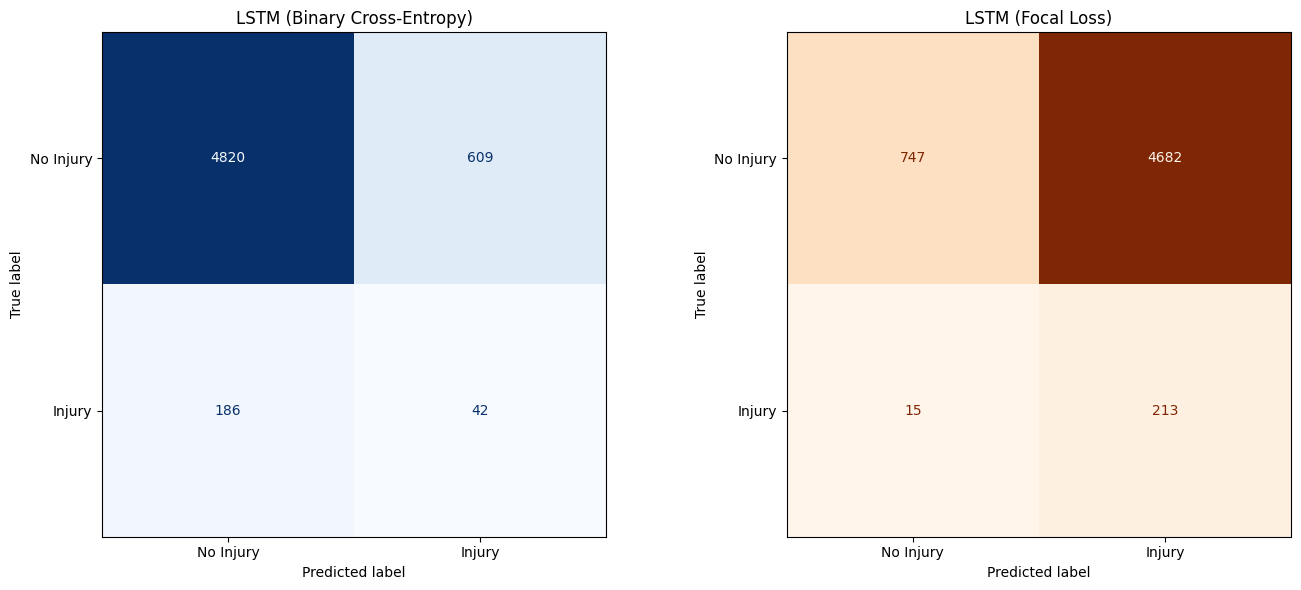

In [1]:
import matplotlib.pyplot as plt
from sklearn.metrics import ConfusionMatrixDisplay
import numpy as np

# Confusion matrices
conf_matrix_bce = np.array([[4820, 609], [186, 42]])       # LSTM
conf_matrix_focal = np.array([[747, 4682], [15, 213]])    # LSTM + Focal

fig, axes = plt.subplots(1, 2, figsize=(14, 6))

# LSTM (Binary Cross-Entropy)
disp_bce = ConfusionMatrixDisplay(confusion_matrix=conf_matrix_bce, display_labels=["No Injury", "Injury"])
disp_bce.plot(ax=axes[0], cmap='Blues', colorbar=False)
axes[0].set_title("LSTM (Binary Cross-Entropy)")

# LSTM (Focal Loss)
disp_focal = ConfusionMatrixDisplay(confusion_matrix=conf_matrix_focal, display_labels=["No Injury", "Injury"])
disp_focal.plot(ax=axes[1], cmap='Oranges', colorbar=False)
axes[1].set_title("LSTM (Focal Loss)")

plt.tight_layout()
plt.show()

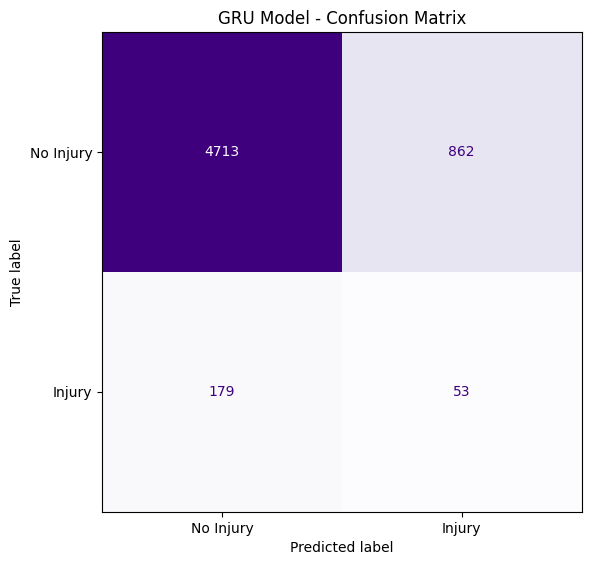

In [2]:
# Confusion matrix for GRU model
conf_matrix_gru = np.array([[4713, 862], [179, 53]])
fig, ax = plt.subplots(figsize=(6, 6))
ConfusionMatrixDisplay(confusion_matrix=conf_matrix_gru, display_labels=["No Injury", "Injury"]).plot(ax=ax, cmap='Purples', colorbar=False)
ax.set_title("GRU Model - Confusion Matrix")
plt.tight_layout()
plt.show()

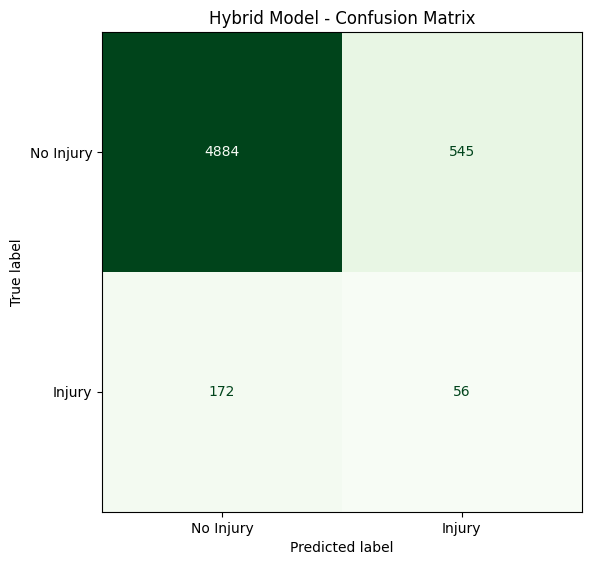

In [3]:
# Confusion matrix for Hybrid model
conf_matrix_hybrid = np.array([[4884, 545], [172, 56]])
fig, ax = plt.subplots(figsize=(6, 6))
ConfusionMatrixDisplay(confusion_matrix=conf_matrix_hybrid, display_labels=["No Injury", "Injury"]).plot(ax=ax, cmap='Greens', colorbar=False)
ax.set_title("Hybrid Model - Confusion Matrix")
plt.tight_layout()
plt.show()